### 15. Image Folder

- 먼저 github에서 다운받은 gray, red 의자 이미지들을 custom_data/orogin_data 폴더에 저장해 놓는다 
- label은 gray = 0, red = 1 이다. 

In [1]:
import torch 
import torchvision 
from torchvision import transforms 
from torch.utils.data import DataLoader 
from matplotlib.pyplot import imshow 

0 <PIL.Image.Image image mode=RGB size=512x256 at 0x280FC3FE5B0> 0


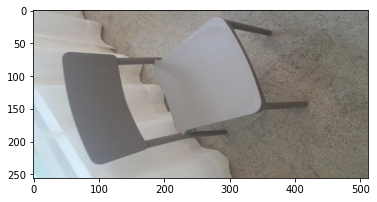

In [2]:
## 원본데이터를 읽어와 train_data에 저장하고, 이미지 정보를 확인해 보자 
train_data = torchvision.datasets.ImageFolder(root = 'custom_data/origin_data', 
                                             transform = None)

for num, value in enumerate(train_data): 
    data, label = value
    print(num, data, label)
    imshow(data)
    break 

0 <PIL.Image.Image image mode=RGB size=128x64 at 0x280CF691A90> 0


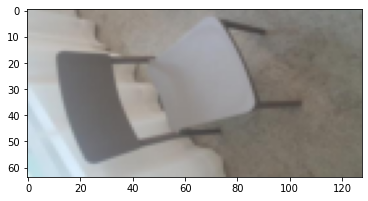

In [3]:
## 이미지 크기가 512x256으로 너무 크다, torchvision.transform의 Compose 함수를 사용하여 사이즈를 줄여주자 
trans = transforms.Compose([
    transforms.Resize((64, 128))
])


train_data = torchvision.datasets.ImageFolder(root = 'custom_data/origin_data', 
                                             transform = trans)   ## transform = trans

for num, value in enumerate(train_data): 
    data, label = value
    print(num, data, label)
    imshow(data)
    break 

In [4]:
## resize 된 데이터를 저장하자 (먼저 저장될 폴더들을 만들어 주어야 한다)
for num, value in enumerate(train_data): 
    data, label = value
    print(num, data, label)
    
    if(label == 0): 
        data.save('custom_data/train_data/gray/%d_%d.jpeg'%(num, label) )
    else : 
        data.save('custom_data/train_data/red/%d_%d.jpeg'%(num, label) )

0 <PIL.Image.Image image mode=RGB size=128x64 at 0x280FC4D6F70> 0
1 <PIL.Image.Image image mode=RGB size=128x64 at 0x280FC50EEE0> 0
2 <PIL.Image.Image image mode=RGB size=128x64 at 0x280FC521790> 0
3 <PIL.Image.Image image mode=RGB size=128x64 at 0x280FC4D6FA0> 0
4 <PIL.Image.Image image mode=RGB size=128x64 at 0x280FC521790> 0
5 <PIL.Image.Image image mode=RGB size=128x64 at 0x280FC50EEE0> 0
6 <PIL.Image.Image image mode=RGB size=128x64 at 0x280FC521790> 0
7 <PIL.Image.Image image mode=RGB size=128x64 at 0x280FC50EEB0> 0
8 <PIL.Image.Image image mode=RGB size=128x64 at 0x280FC521790> 0
9 <PIL.Image.Image image mode=RGB size=128x64 at 0x280FC50EF70> 0
10 <PIL.Image.Image image mode=RGB size=128x64 at 0x280FC521790> 0
11 <PIL.Image.Image image mode=RGB size=128x64 at 0x280FC50EEE0> 0
12 <PIL.Image.Image image mode=RGB size=128x64 at 0x280FC521790> 0
13 <PIL.Image.Image image mode=RGB size=128x64 at 0x280FC50EEB0> 0
14 <PIL.Image.Image image mode=RGB size=128x64 at 0x280FC521790> 0
15 <P

- Neural Network 만들기 

<img src = 'img/image_folder.png'>

In [8]:
import torch 
import torch.nn as nn
import torch.functional as F 
from torch.utils.data import DataLoader 
import torchvision 
import torchvision.transforms as transforms 
device = 'cpu'

import timeit

In [9]:
### train_data를 tensor로 변환 --> dataloader로 읽어들인다. 
trans = transforms.Compose([
    transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(root = 'custom_data/train_data', 
                                              transform = trans)

data_loader = DataLoader(dataset = train_data, 
                         batch_size = 8, 
                         shuffle = True, 
                         num_workers=2)

In [10]:
## CNN 

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,6,5),    ## input, output, filter size
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(16*13*29, 120),
            nn.ReLU(),
            nn.Linear(120,2)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        print(out.shape)      ### 각 레이어를 통과한 결과를 바로 확인하기 위해 
        out = self.layer2(out)
        print(out.shape)
        out = out.view(out.shape[0], -1)
        print(out.shape)
        out = self.layer3(out)
        return out

In [17]:
### CNN이 제대로 작동하는지 확인하기 위한 코드 
### 각 레이어를 통과한 output의 shape가 차례대로 출력된다. 
net = CNN().to(device)
test_input = (torch.Tensor(3,3,64,128)).to(device)
test_out = net(test_input)

torch.Size([3, 6, 30, 62])
torch.Size([3, 16, 13, 29])
torch.Size([3, 6032])


In [18]:
## model, cost, optimizer 
net = CNN().to(device)
loss_func = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.00005)

In [25]:
## training 
total_batch = len(data_loader)

epochs = 5
for epoch in range(epochs) : 
    avg_cost = 0
    
    for num, data in enumerate(data_loader) : 
        imgs, labels = data
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        out = net(imgs)
        loss = loss_func(out, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_cost += loss / total_batch
    print('epoch:', epoch+1, 'cost=', avg_cost)

torch.Size([8, 6, 30, 62])
torch.Size([8, 16, 13, 29])
torch.Size([8, 6032])
torch.Size([8, 6, 30, 62])
torch.Size([8, 16, 13, 29])
torch.Size([8, 6032])
torch.Size([8, 6, 30, 62])
torch.Size([8, 16, 13, 29])
torch.Size([8, 6032])
torch.Size([8, 6, 30, 62])
torch.Size([8, 16, 13, 29])
torch.Size([8, 6032])
torch.Size([8, 6, 30, 62])
torch.Size([8, 16, 13, 29])
torch.Size([8, 6032])
torch.Size([8, 6, 30, 62])
torch.Size([8, 16, 13, 29])
torch.Size([8, 6032])
torch.Size([8, 6, 30, 62])
torch.Size([8, 16, 13, 29])
torch.Size([8, 6032])
torch.Size([8, 6, 30, 62])
torch.Size([8, 16, 13, 29])
torch.Size([8, 6032])
torch.Size([8, 6, 30, 62])
torch.Size([8, 16, 13, 29])
torch.Size([8, 6032])
torch.Size([8, 6, 30, 62])
torch.Size([8, 16, 13, 29])
torch.Size([8, 6032])
torch.Size([8, 6, 30, 62])
torch.Size([8, 16, 13, 29])
torch.Size([8, 6032])
torch.Size([8, 6, 30, 62])
torch.Size([8, 16, 13, 29])
torch.Size([8, 6032])
torch.Size([8, 6, 30, 62])
torch.Size([8, 16, 13, 29])
torch.Size([8, 6032])

In [26]:
## validation with test_data
trans=torchvision.transforms.Compose([
    transforms.Resize((64,128)),
    transforms.ToTensor()
])

test_data = torchvision.datasets.ImageFolder(root='custom_data/test_data', transform=trans)

test_set = DataLoader(dataset = test_data, batch_size = len(test_data))

In [27]:
with torch.no_grad():
    for num, data in enumerate(test_set):
        imgs, label = data
        imgs = imgs.to(device)
        label = label.to(device)
        
        prediction = net(imgs)
        correct_prediction = torch.argmax(prediction, 1) == label
        accuracy = correct_prediction.float().mean()
        print('Accuracy:', accuracy.item())

torch.Size([50, 6, 30, 62])
torch.Size([50, 16, 13, 29])
torch.Size([50, 6032])
Accuracy: 1.0
